In [2]:
import pandas as pd
import numpy as np

import numba

import bebi103

import altair as alt
import altair_catplot as altcat

import bokeh.io
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

In [3]:
df = pd.read_csv('../data/hw_4.2_caulobacter_growth_image_processing_results.csv')

df.head()

,time (min),area (sq um),growth_event,bacterium
0,1.0,1.300624,0,1
1,2.0,1.314144,0,1
2,3.0,1.295216,0,1
3,4.0,1.314144,0,1
4,5.0,1.341184,0,1


### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [104]:
def c_ab(c_a, c_b, k_d):
    return (2 * c_a * c_b) / (k_d + c_a + c_b + np.sqrt((k_d + c_a + c_b)**2 - 4 * c_a * c_b))

def f(f_0, f_q, c_a, c_b, k_d):
    return f_0 * c_a - (f_0 - f_q) * c_ab(c_a, c_b, k_d)

In [46]:
df = pd.read_csv('../data/fret_binding_curve.csv', comment='#')

df

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.000000
1,1256.5751,267722.6277,50.0,750.000000
2,1256.5751,267431.6620,50.0,375.000000
3,1256.5751,284596.2914,50.0,187.500000
4,1256.5751,254903.3958,50.0,93.750000
5,1256.5751,333810.6371,50.0,46.875000
6,1256.5751,370821.7778,50.0,23.437500
7,1256.5751,408856.1424,50.0,11.718750
8,1256.5751,431000.0000,50.0,5.859375
9,1256.5751,437000.0000,50.0,0.000000


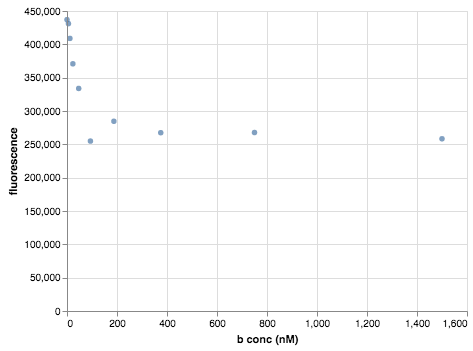

In [120]:
alt.Chart(
    df
).mark_circle(
).encode(
    x='b conc (nM):Q',
    y='fluorescence:Q'
)

In [125]:
def prior_pred_gen(c_a, c_b):
    """Generate prior predictive data set."""
    k_d = np.random.lognormal(0.01, 1)
    f_0 = np.random.normal(8000,500)
    f_q = np.random.normal(5000,500)
    sigma = np.abs(np.random.normal(0, 0.1))
    
    f_theor = f(f_0, f_q, c_a, c_b, k_d)

    return np.random.normal(f_theor, sigma)

Let's take 100 samples for c_a = 50 mM and c_b = 0 mM and see what kind of total fluorescnece values we get.

In [126]:
t = np.arange(0,100,1.0)
c_a = 50
c_b = 0

p = bokeh.plotting.figure(height=300, width=500)

# Compute f 100 times
f_theor = np.zeros(100)
for i in range(100):
    f_theor[i] = prior_pred_gen(c_a, c_b)
    
p = bebi103.viz.ecdf(f_theor)
bokeh.io.show(p)

This looks fine so let's check for c_a = 50 mM and c_b = 1500 mM.

In [127]:
t = np.arange(0,100,1.0)
c_a = 50
c_b = 1500

p = bokeh.plotting.figure(height=300, width=500)

# Compute f 100 times
f_theor = np.zeros(100)
for i in range(100):
    f_theor[i] = prior_pred_gen(c_a, c_b)
    
# Sort in ascending order 
f_theor.sort()

# Plot
p = bebi103.viz.ecdf(f_theor)
bokeh.io.show(p)

In [49]:
df['norm fluorescence'] = df['fluorescence'] / 1000000

In [50]:
df

,buffer,fluorescence,a conc (nM),b conc (nM),norm fluorescence
0,1256.5751,258316.2818,50.0,1500.000000,0.258316
1,1256.5751,267722.6277,50.0,750.000000,0.267723
2,1256.5751,267431.6620,50.0,375.000000,0.267432
3,1256.5751,284596.2914,50.0,187.500000,0.284596
4,1256.5751,254903.3958,50.0,93.750000,0.254903
5,1256.5751,333810.6371,50.0,46.875000,0.333811
6,1256.5751,370821.7778,50.0,23.437500,0.370822
7,1256.5751,408856.1424,50.0,11.718750,0.408856
8,1256.5751,431000.0000,50.0,5.859375,0.431000
9,1256.5751,437000.0000,50.0,0.000000,0.437000


In [119]:
# def prior_pred_gen(c_a, c_b):
#     """Generate prior predictive data set."""
#     k_d = np.random.lognormal(0, 1)
#     f_0 = np.random.beta(10, 1.2)
#     f_q = np.random.beta(0.5, 7)
#     sigma = np.abs(np.random.normal(0, 0.1))
    
#     f_theor = f(f_0, f_q, c_a, c_b, k_d)

#     return np.random.normal(f_theor, sigma)

# t = np.arange(0,100,1.0)
# c_a = 50
# c_b = 5

# p = bokeh.plotting.figure(height=300, width=500)

# # Compute f 100 times
# f_theor = np.zeros(100)
# for i in range(100):
#     f_theor[i] = prior_pred_gen(c_a, c_b)
    
# # Sort in ascending order 
# f_theor.sort()

# # Plot
# p.circle(t, f_theor)
# bokeh.io.show(p)